In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import os
import random
import scipy.io as sio
import struct

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
project_dir = os.path.abspath("../")
datasets_dir = os.path.join(project_dir, "datasets")
affNIST_dir = os.path.join(datasets_dir, "affNIST")
NORB_dir = os.path.join(datasets_dir, "NORB")
smallNORB_dir = os.path.join(datasets_dir, "smallNORB")

In [4]:
affNIST_just_centered_dir = os.path.join(affNIST_dir, "just_centered")
affNIST_original_dir = os.path.join(affNIST_dir, "original")
affNIST_transformed_dir = os.path.join(affNIST_dir, "transformed")

affNIST_transformed_training_batches_dir = os.path.join(affNIST_transformed_dir, 
                                                                        "training_batches")
affNIST_transformed_validation_batches_dir = os.path.join(affNIST_transformed_dir, 
                                                                        "validation_batches")
affNIST_transformed_training_and_validation_batches_dir = os.path.join(affNIST_transformed_dir,
                                                                        "training_and_validation_batches")
affNIST_transformed_test_batches_dir = os.path.join(affNIST_transformed_dir, 
                                                                        "test_batches")

In [5]:
class affNISTDataset(Dataset):
    """
    This is a custom Pytorch Dataset implementation
    for the affNISTDataset.
    
    The affNIST dataset for machine learning is based 
    on the well-known MNIST dataset. MNIST, however, 
    has become quite a small set, given the power of 
    today's computers, with their multiple CPU's and 
    sometimes GPU's. affNIST is made by taking images 
    from MNIST and applying various reasonable affine 
    transformations to them. In the process, the images
    become 40x40 pixels large, with significant translations
    involved, so much of the challenge for the models is 
    to learn that a digit means the same thing in the 
    upper right corner as it does in the lower left corner.

    Research into "capsules" has suggested that it is 
    beneficial to directly model the position (or more 
    general "pose") in which an object is found. 
    affNIST aims to facilitate that by providing the
    exact transformation that has been applied to make
    each data case, as well as the original 28x28 image. 
    This allows one to train a model to normalize the 
    input, or to at least recognize in which ways it has
    been deformed from a more normal image.

    Another effect of the transformations is that there 
    is simply much more data: every original MNIST image
    has been transformed in many different ways. In theory
    it's an infinite dataset; in practice it's based on 
    70,000 originals and I've made 32 randomly chosen 
    transformed versions of each original (a different 32
    for each original), leading to a total of about two 
    million training + validation cases.
    """
    
    def __init__(self, affNIST_dir, split, transform=None):
        
        assert isinstance(affNIST_dir, str) and os.path.exists(affNIST_dir)
        assert split in ["training", "validation", "test"]
        assert callable(transform) or transform is None
        
        self.DATASET = "affNIST"
        self.IMG_HEIGHT = 40
        self.IMG_WIDTH = 40
        self.IMG_DIM = (40, 40)
        
        
        
        self.n_classes = 10       
        self.label2category = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
        self.category2label = {category : label for label, category in enumerate(self.label2category)}
        
        
        self.split = split
        self.SUFFIX = ".mat"
        
        self.just_centered_FILE_NAME = split + self.SUFFIX
        self.transformed_FOLDER_NAME = split + "_batches"
        
        self.affNIST_dir = affNIST_dir
        
        self.just_centered_dir = os.path.join(affNIST_dir, "just_centered")
        self.transformed_dir = os.path.join(affNIST_dir, "transformed")
        
        self.just_centered_FILE = os.path.join(self.just_centered_dir, self.just_centered_FILE_NAME)
        self.transformed_FILE_PATH = os.path.join(self.transformed_dir, self.transformed_FOLDER_NAME)
        
        
        self.transform = transform   
        
        self.X, self.y = self.load_dataset()
        self.n_samples = self.X.shape[0]
    
    
    def __len__(self):
        """
        Returns:
            (int): the length of the dataset
        """
        return self.n_samples
    
        
    def __getitem__(self, index):
        """
        Returns the _transformed_ item from the dataset
        Args:
            index (int): the index of the data sample to get
        Returns:
            (tuple):
                * img (torch.Tensor): 2-D array representation of the data sample
                * label (int): the class label of the data sample
        """
        img = self.transform(self.X[index]) if self.transform else self.X[index]
        label = self.y[index]
        return img, label   
    
    
    def load_dataset(self):    

            # Load "just_centered" data
#           file_path = ...  
            
            X = sio.loadmat(self.just_centered_FILE)['affNISTdata'][0][0][2].transpose().reshape(-1,40,40)
            y = sio.loadmat(self.just_centered_FILE)['affNISTdata'][0][0][5].ravel()

            # Load "transformed" data
            for file in os.listdir(self.transformed_FILE_PATH):
                file = os.path.join(self.transformed_FILE_PATH, file)
                X = np.vstack((X, sio.loadmat(file)['affNISTdata'][0][0][2].transpose().reshape(-1,40,40)))
                y = np.hstack((y, sio.loadmat(file)['affNISTdata'][0][0][5].ravel()))
            
            # Normalize data between (0,1)
            
            
            return torch.from_numpy(X)/256, torch.from_numpy(y)
    
    def getCategoryFromLabel(self, index):
        label = self.y[index]
        return label2category[label] 
    
    def getData(self):
        return self.X, self.y
    

In [6]:
class smallNORBDataset(Dataset):
    
    
    def __init__(self, smallNORB_dir, split, transform=None):
        
        assert isinstance(smallNORB_dir, str) and os.path.exists(smallNORB_dir)
        assert split in ["training", "testing"]
        assert callable(transform) or transform is None
        
        self.DATASET = "smallNORB"
        
        self.IMG_HEIGHT = 96
        self.IMG_WIDTH = 96
        self.IMG_DIM = (96, 96)
        
        self.n_classes = 5        
        self.label2category = ['animal', 'human', 'airplane', 'truck', 'car']
        self.category2label = {category : label for label, category in enumerate(self.label2category)}
        
        
        
        self.smallNORB_dir = smallNORB_dir
        self.transform = transform


        self.FILE_PREFIXES = {"training" : "smallnorb-5x46789x9x18x6x2x96x96-",
                              "testing"  : "smallnorb-5x01235x9x18x6x2x96x96-" }
        
        self.FILE_PREFIX = self.FILE_PREFIXES[split]
        self.split = split
        self.FILE_TYPES = ["dat", "cat", "info"]
        self.SUFFIX = ".mat"


        self.files = [self.FILE_PREFIX + self.split + '-' + f_type + self.SUFFIX for f_type in self.FILE_TYPES]
        self.dat_file, self.cat_file, self.info_file = self.files

        
        self.filepaths = [os.path.join(smallNORB_dir, file) for file in self.files]
        self.dat_filepath, self.cat_filepath, self.info_filepath = self.filepaths

        self.X, self.y, (self.instance, self.elevation, self.azimuth, self.lighting) = self.load_dataset()
        
        self.n_samples = self.X.shape[0]
    
        
    def load_dataset(self):
        
        map_magic_number_to_data_type = {
            '1e3d4c55': np.uint8,
            '1e3d4c54': np.int32 
        }
        
        data_lst = []
        for filepath, f_type in zip(self.filepaths,self.FILE_TYPES):
            with open(filepath, 'rb') as f:

                read_next_int = lambda file: struct.unpack('i', file.read(4))[0]

                # get header
                raw_magic_num = read_next_int(f)
                magic_num = '{:02x}'.format(raw_magic_num)

                # get data type
                data_type = map_magic_number_to_data_type[magic_num]

                # get data dimensions
                ndim = read_next_int(f)

                # get data shape
                shape = [read_next_int(f) for i in range(max(ndim,3))]
                shape = shape[:ndim]

                # get data
                data = np.fromfile(f, dtype=data_type, count=np.prod(shape)).reshape(shape)
                
                
                if f_type == "dat":
                    data = data.reshape(-1, self.IMG_HEIGHT, self.IMG_WIDTH).astype('float64')/256
                elif f_type == "cat":
                    data = np.insert(data, np.arange(data.shape[0]), data)
                elif f_type == "info":
                    data = np.transpose(np.insert(data, np.arange(data.shape[0]), data, axis = 0))
                
                data_lst.append(torch.from_numpy(data))

        return data_lst
    
    
    
    def __len__(self):
        """
        Returns:
            (int): the length of the dataset
        """
        return self.n_samples
    
        
    def __getitem__(self, index):
        """
        Returns the _transformed_ item from the dataset
        Args:
            index (int): the index of the data sample to get
        Returns:
            (tuple):
                * img_data (torch.Tensor): 2-D array representation of the data sample
                * img_label (int): the class label of the data sample
        """
        
        img = self.transform(self.X[index]) if self.transform else self.X[index]
        label = self.y[index]
        return img, label
    
    
    def getCategoryFromLabel(self, index):
        label = self.y[index]
        return label2category[label]        
    
    def getInstance(self, index):
        return self.instance[index]
    
    def getElevation(self, index):
        return self.elevation[index]
    
    def getAzimuth(self, index):
        return self.azimuth[index]
    
    def getLighting(self, index):
        return self.lighting[index]
    
    def getData(self):
        return self.X, self.y
    
    

In [7]:
train_set_affNIST = affNISTDataset(affNIST_dir, "training")
val_set_affNIST = affNISTDataset(affNIST_dir, "validation")
test_set_affNIST = affNISTDataset(affNIST_dir, "test")

In [8]:
train_set_smallNORB = smallNORBDataset(smallNORB_dir, "training") 
test_set_smallNORB = smallNORBDataset(smallNORB_dir, "testing")

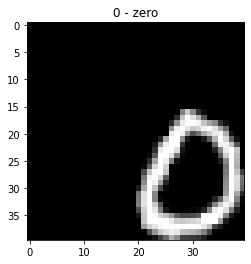

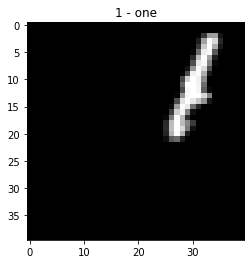

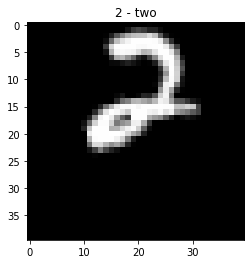

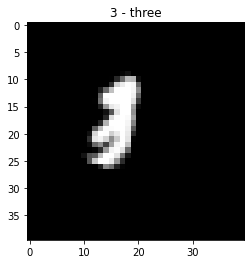

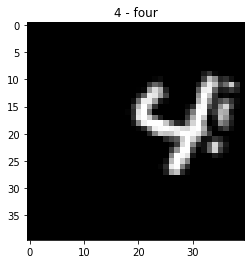

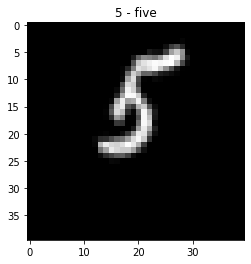

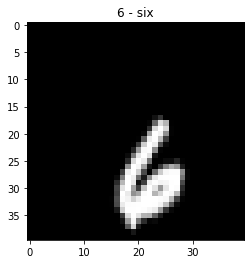

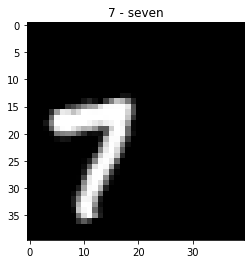

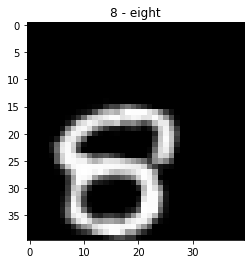

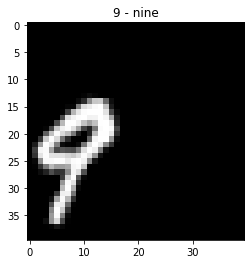

In [11]:
# affNIST show one item per class
for i in range(10):
    r = random.randint(0, train_set_affNIST.n_samples)
    image, label = train_set_affNIST[r]
    while label != i :
        r = random.randint(0, train_set_affNIST.n_samples)
        image, label = train_set_affNIST[r]
    plt.figure()
    cat = train_set_affNIST.label2category[label.item()]
    plt.title(f'{label.item()} - {cat}')
    plt.imshow(image,'gray')


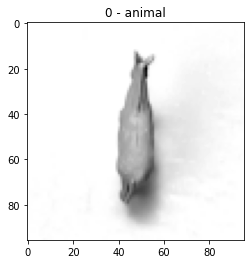

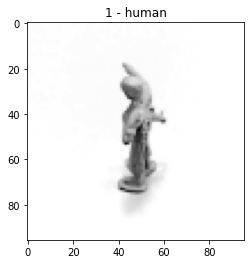

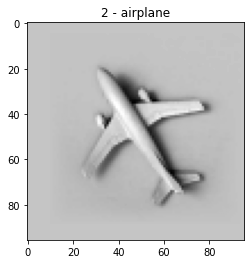

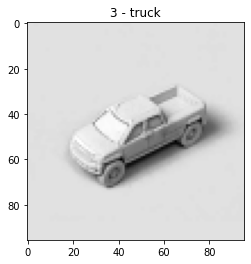

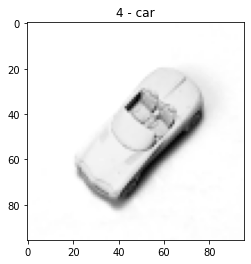

In [12]:
# smallNORB show one item per class
for i in range(5):
    r = random.randint(0, train_set_smallNORB.n_samples)
    image, label = train_set_smallNORB[r]
    while label != i :
        r = random.randint(0, train_set_smallNORB.n_samples)
        image, label = train_set_smallNORB[r]
    plt.figure()
    cat = train_set_smallNORB.label2category[label.item()]
    plt.title(f'{label.item()} - {cat}')
    plt.imshow(image,'gray')    


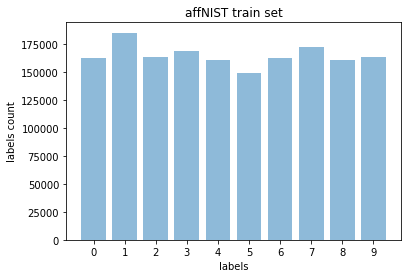

In [13]:
unique, counts = np.unique(train_set_affNIST.y, return_counts=True)
plt.figure()
plt.bar(unique, counts, align='center', alpha=0.5)
plt.xticks(unique)
plt.xlabel('labels')
plt.ylabel('labels count')
plt.title('affNIST train set')
plt.show()

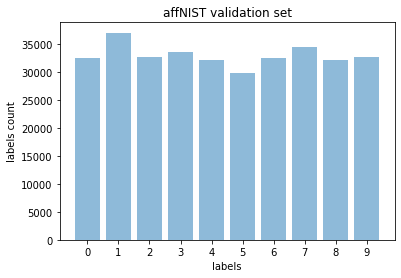

In [14]:
unique, counts = np.unique(val_set_affNIST.y, return_counts=True)
plt.figure()
plt.bar(unique, counts, align='center', alpha=0.5)
plt.xticks(unique)
plt.xlabel('labels')
plt.ylabel('labels count')
plt.title('affNIST validation set')
plt.show()

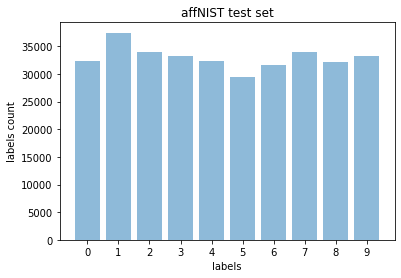

In [15]:
unique, counts = np.unique(test_set_affNIST.y, return_counts=True)
plt.figure()
plt.bar(unique, counts, align='center', alpha=0.5)
plt.xticks(unique)
plt.xlabel('labels')
plt.ylabel('labels count')
plt.title('affNIST test set')
plt.show()

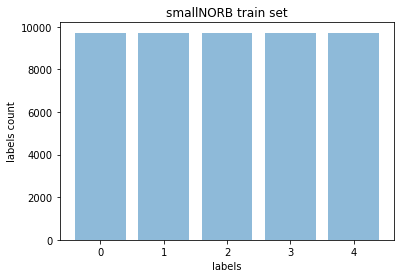

In [16]:
unique, counts = np.unique(train_set_smallNORB.y, return_counts=True)
plt.figure()
plt.bar(unique, counts, align='center', alpha=0.5)
plt.xlabel('labels')
plt.ylabel('labels count')
plt.title('smallNORB train set')
plt.show()

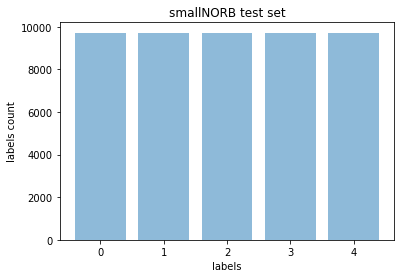

In [17]:
unique, counts = np.unique(test_set_smallNORB.y, return_counts=True)
plt.figure()
plt.bar(unique, counts, align='center', alpha=0.5)
plt.xlabel('labels')
plt.ylabel('labels count')
plt.title('smallNORB test set')
plt.show()

In [18]:
train_dataloader_affNIST = DataLoader(train_set_affNIST, batch_size=64, shuffle=True)
val_dataloader_affNIST = DataLoader(val_set_affNIST, batch_size=64, shuffle=True)
test_dataloader_affNIST = DataLoader(test_set_affNIST, batch_size=64, shuffle=True)

In [19]:
train_dataloader_smallNORB = DataLoader(train_set_smallNORB, batch_size=64, shuffle=True)
test_dataloader_smallNORB = DataLoader(test_set_smallNORB, batch_size=64, shuffle=True)